In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
SEED=10
np.random.seed(SEED)

In [3]:
df = pd.read_csv('marketing_campaign.csv', sep='\t')
print(df.shape)
df.head()

(2240, 29)


,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0


![](https://www.googleapis.com/download/storage/v1/b/kaggle-forum-message-attachments/o/inbox%2F1327132%2F0c83aef015cef72a1c6ef0bdb18937f3%2Fcolumns%20meaning%20small.png?generation=1609671531255584&alt=media)

# Data Cleaning

**Marital Status Column**

In [4]:
df.isnull().sum()

ID                      0
Year_Birth              0
Education               0
Marital_Status          0
Income                 24
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
AcceptedCmp1            0
AcceptedCmp2            0
Complain                0
Z_CostContact           0
Z_Revenue               0
Response                0
dtype: int64

There are missing values in the income column. The null values are quite insignificant so it's easier to drop the rows

In [5]:
df.dropna(how='any', inplace=True)

In [6]:
df['Marital_Status'].value_counts()

Married     857
Together    573
Single      471
Divorced    232
Widow        76
Alone         3
YOLO          2
Absurd        2
Name: Marital_Status, dtype: int64

The marital status column has very weird names such as 'alone','absurd' and 'yolo'. We will rename the categories

In [7]:
dictionary = {'Together':'Married',
              'Divorced':'Single',
              'Widow':'Single',
              'Alone':'Single',
              'Absurd':'Single',
              'YOLO':'Single'}

for key in dictionary.keys():
  df['Marital_Status'] = df['Marital_Status'].str.replace(key, dictionary[key])
df['Marital_Status'].value_counts()

Married    1430
Single      786
Name: Marital_Status, dtype: int64

**Education Column**

In [8]:
df['Education'].value_counts()

Graduation    1116
PhD            481
Master         365
2n Cycle       200
Basic           54
Name: Education, dtype: int64

In [9]:
df['Education'] = df['Education'].str.replace('2n Cycle','Master')

**Dt_Customer Column** 

In [10]:
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'])
df['Dt_Customer'] = df['Dt_Customer'].dt.year

In [11]:
df.drop('ID', axis=1, inplace=True)

In [12]:
df.describe()

,Year_Birth,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
count,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.0,2216.0,2216.000000
mean,1968.820397,52247.251354,0.441787,0.505415,2013.028430,49.012635,305.091606,26.356047,166.995939,37.637635,27.028881,43.965253,2.323556,4.085289,2.671029,5.800993,5.319043,0.073556,0.074007,0.073105,0.064079,0.013538,0.009477,3.0,11.0,0.150271
std,11.985554,25173.076661,0.536896,0.544181,0.685618,28.948352,337.327920,39.793917,224.283273,54.752082,41.072046,51.815414,1.923716,2.740951,2.926734,3.250785,2.425359,0.261106,0.261842,0.260367,0.244950,0.115588,0.096907,0.0,0.0,0.357417
min,1893.000000,1730.000000,0.000000,0.000000,2012.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
25%,1959.000000,35303.000000,0.000000,0.000000,2013.000000,24.000000,24.000000,2.000000,16.000000,3.000000,1.000000,9.000000,1.000000,2.000000,0.000000,3.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
50%,1970.000000,51381.500000,0.000000,0.000000,2013.000000,49.000000,174.500000,8.000000,68.000000,12.000000,8.000000,24.500000,2.000000,4.000000,2.000000,5.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
75%,1977.000000,68522.000000,1.000000,1.000000,2013.000000,74.000000,505.000000,33.000000,232.250000,50.000000,33.000000,56.000000,3.000000,6.000000,4.000000,8.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
max,1996.000000,666666.000000,2.000000,2.000000,2014.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,262.000000,321.000000,15.000000,27.000000,28.000000,13.000000,20.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.0,11.0,1.000000


# Feature Enginnering
* **Dependants:**The total number of dependants can be engineered from the sum of 'Kidhome' and 'Teenhome'<br>
* **TotalMnt:** The total amount spent can be engineered from the sum of all features containing the keyword 'Mnt'<br>
* **TotalPurchases:** The total purchases can be engineered from the sum of all the features containing the keyword 'purchases'<br>
* **TotalCampaignAcc:** The total number of campaigns accepted can be engineered from the sum of all features containing the keywords 'Cmp' and 'Response'
* **Age:** Extract birth year of the respective person<br>
* **IsParent:** Whether the customer has achild or not

In [13]:
# Dependants
df['Dependants'] = df['Kidhome'] + df['Teenhome']

# Total Amount Spent
mnt_cols = [col for col in df.columns if 'Mnt' in col]
df['TotalMnt'] = df[mnt_cols].sum(axis=1)

# Total Purchases
purchases_cols = [col for col in df.columns if 'Purchases' in col]
df['TotalPurchases'] = df[purchases_cols].sum(axis=1)

# Total Campaigns accepted
campaign_cols = [col for col in df.columns if 'Cmp' in col] + ['Response']
df['TotalCampaignsAcc'] = df[campaign_cols].sum(axis=1)

# Age of the customer(use 2014 as its the most recent year)
df['Age'] = 2014 - df['Year_Birth']

# Total Members
df['Is_Parent'] = np.where(df['Dependants'] > 0, 1, 0)

# Drop redundant columns
df.drop(['Z_CostContact','Z_Revenue'], axis=1, inplace=True)

df[['Dependants','TotalMnt','TotalPurchases','TotalCampaignsAcc','Age','Is_Parent']].head()

,Dependants,TotalMnt,TotalPurchases,TotalCampaignsAcc,Age,Is_Parent
0,0,1617,25,1,57,0
1,2,27,6,0,60,1
2,0,776,21,0,49,0
3,1,53,8,0,30,1
4,1,422,19,0,33,1


**Analysing Patterns or Anomalies**

<Figure size 1008x720 with 0 Axes>

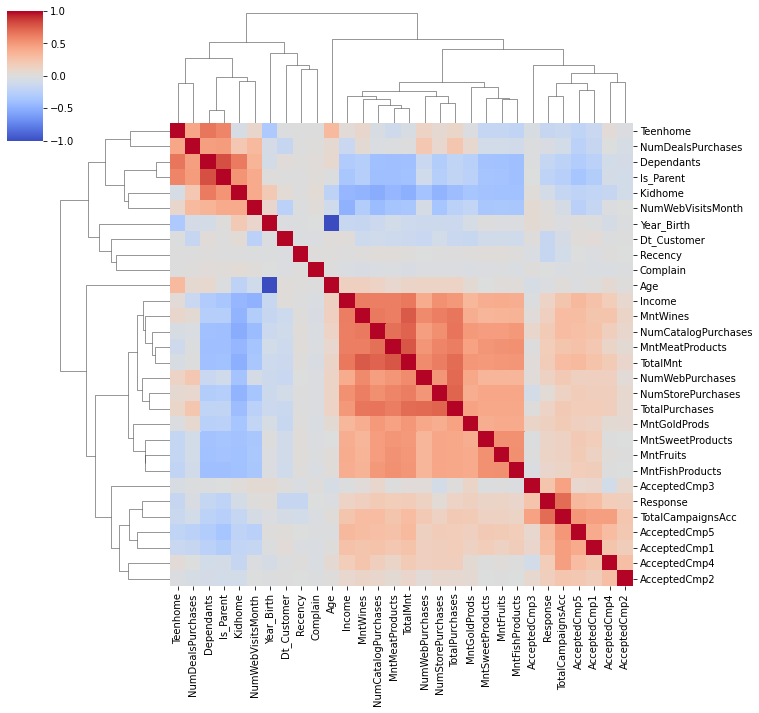

In [14]:
# Calculate correlation matrix
# We will use kendall since some features are binary
plt.figure(figsize=(14,10))
corr = df.select_dtypes(include=np.number).corr(method='kendall')
sns.clustermap(corr, cbar_pos=(-0.05, 0.8, 0.05, 0.18), cmap='coolwarm', center=0)
plt.show()

1.The **have kids & teens** cluster:<br>
> * Amount spent('TotalMnt' and other 'Mnt' features) and Purchases('TotalPurchases' and other 'num..Purchases' features) are negatively correlated with Dependents('Teenhome','Is_Parent','Kidhome')
> * Purchasing deals('NumDealsPurchases') is posiively correlated with 'Dependents' and negatively correlated with 'income


2.The **high income** cluster:
> * Amount spent('TotalMnt' and other 'Mnt' features) and number of purchases('TotalPurchases' and other 'Num..Purchases' features)are positively correlated with income.
> * Purchasing in store, on the web, or via catalog is positively correlated with 'income'

3.The **Advertising Campaigns** cluster:
> * Acceptance of the campaigns('AcceptedCmp' and 'Response' are strongly positively correlated with each other.
> * Weak positive correlation of the advertising campaigns is seen with the 'High Income' cluster, and weak negative correlation is seen with the 'Have kids& teens' cluster'


**Anomalies**
* Surprisingly, the number of website visitors in the last month('NumWebVisitsMonth') does not correlate with an increased number of web purchases('NumWebPurchases')<br>
*Instead 'NumWebVisitsMonth' is positively correlated with the number of deals purchased('NumDealsPurchases') suggesting that the deals are an effective way of stimulating purchases on the website

## Remove Outliers

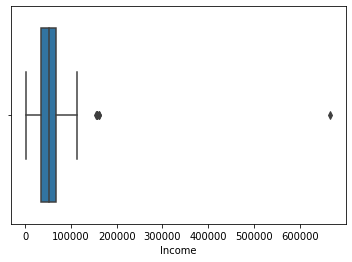

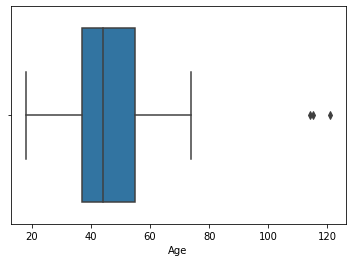

In [15]:
# sns.set(rc={'axes.facecolor':'black', 'figure.facecolor':'black', 'axes.grid' : False, 'font.family': 'Ubuntu'})
num_cols=['Income','Age']
for col in num_cols:
  sns.boxplot(df[col])
  plt.show()


In [16]:
def remove_outliers(df, col):
  mean = df[col].mean()
  std = df[col].std()
  cut_off = std *3
  lower, upper = mean - cut_off, mean + cut_off
  print(f'Original shape is {df.shape}')
  df = df[(df[col] < upper) & (df[col] > lower)]
  print(f'New shape is {df.shape}')


remove_outliers(df,'Age')
remove_outliers(df,'Income')


Original shape is (2216, 32)
New shape is (2213, 32)
Original shape is (2216, 32)
New shape is (2208, 32)


**Label Encoding the categorical columns**

In [17]:
cat_columns =df.select_dtypes(include='object').columns.tolist()
from sklearn.preprocessing import LabelEncoder
encoder= LabelEncoder()
for col in cat_columns:
  df[col] = encoder.fit_transform(df[col])


In [18]:
df.head()

,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Dependants,TotalMnt,TotalPurchases,TotalCampaignsAcc,Age,Is_Parent
0,1957,1,1,58138.0,0,0,2012,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,1,0,1617,25,1,57,0
1,1954,1,1,46344.0,1,1,2014,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,0,2,27,6,0,60,1
2,1965,1,0,71613.0,0,0,2013,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,0,0,776,21,0,49,0
3,1984,1,0,26646.0,1,0,2014,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,0,1,53,8,0,30,1
4,1981,3,0,58293.0,1,0,2014,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,0,1,422,19,0,33,1


# Statistical Analysis
**What factors are significantly related to the number of store purchases**<br>
We will use a linear Regression model with 'NumStorePurchases' as the target ariable and then use machine learning explainability techniques to get insights about which features predict te number of store purchases

Text(0, 0.5, 'Count')

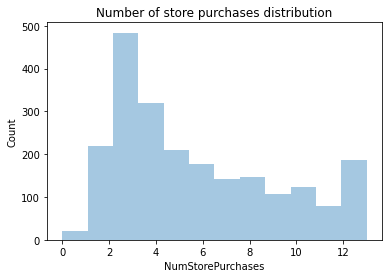

In [19]:
sns.distplot(df['NumStorePurchases'], kde=False, hist=True, bins=12)
plt.title('Number of store purchases distribution', size=12)
plt.ylabel('Count')

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
df2 = df.copy(deep=True)
X = df2.drop('NumStorePurchases', axis=1)
y = df2['NumStorePurchases']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
# fit the regression
model = LinearRegression()
model.fit(X_train, y_train)
pred = model.predict(X_test)

# Evaluate
print(f'Linear Regression model RMSE:{np.sqrt(mean_squared_error(y_test, pred))}')

Linear Regression model RMSE:1.6544761784590737e-14


**Feature Importance**

In [23]:
# !pip install eli5
import eli5
from eli5.sklearn import PermutationImportance
perm = PermutationImportance(model, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names=X_test.columns.tolist(), top=5)

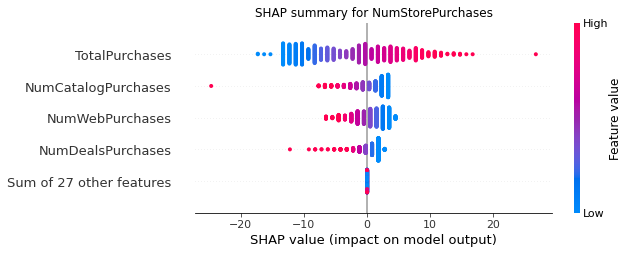

In [25]:
# !pip install shap
import shap
ex = shap.Explainer(model, X_train)
shap_values = ex(X_test)
#Plot
plt.title('SHAP summary for NumStorePurchases')
shap.plots.beeswarm(shap_values, max_display=5)

* **Findings**<br>
> 1.The number of store purchases increases with higher number of total purchases('TotalPurchases')
>2.The number of store purchases decreases with higher number of catalog, web, or deals purchases('NumCatalogPurchases','NumWebPurchases','NumDealsPurchases;)<br>

* **Interpretation**
> Customers who shop the most are those who shop less via the catalog, website or special deals

**Scaling the Data**

In [26]:
data = df.drop(campaign_cols, axis=1)
data = df.drop('TotalCampaignsAcc', axis=1)
# We will use StandardScaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_data = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)
scaled_data.head()

,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Dependants,TotalMnt,TotalPurchases,Age,Is_Parent
0,-0.986443,-0.791254,1.348829,0.234063,-0.823039,-0.928972,-1.500343,0.310532,0.978226,1.549429,1.690227,2.454568,1.484827,0.850031,0.351713,1.428553,2.504712,-0.554143,0.693232,-0.281773,-0.282705,-0.280839,-0.261661,-0.117148,-0.097812,2.377952,-1.264803,1.675488,1.319446,0.986443,-1.581389
1,-1.236801,-0.791254,1.348829,-0.234559,1.039938,0.909066,1.417393,-0.380509,-0.872024,-0.637328,-0.717986,-0.651038,-0.633880,-0.732867,-0.168231,-1.125881,-0.571082,-1.169518,-0.131574,-0.281773,-0.282705,-0.280839,-0.261661,-0.117148,-0.097812,-0.420530,1.405806,-0.962358,-1.157987,1.236801,0.632356
2,-0.318822,-0.791254,-0.741384,0.769478,-0.823039,-0.928972,-0.041475,-0.795134,0.358511,0.569159,-0.178368,1.340203,-0.146821,-0.037937,-0.688176,1.428553,-0.229327,1.291982,-0.543978,-0.281773,-0.282705,-0.280839,-0.261661,-0.117148,-0.097812,-0.420530,-1.264803,0.280250,0.797881,0.318822,-1.581389
3,1.266777,-0.791254,-0.741384,-1.017239,1.039938,-0.928972,1.417393,-0.795134,-0.872024,-0.561922,-0.655551,-0.504892,-0.585174,-0.752171,-0.168231,-0.760962,-0.912837,-0.554143,0.280829,-0.281773,-0.282705,-0.280839,-0.261661,-0.117148,-0.097812,-0.420530,0.070501,-0.919224,-0.897205,-1.266777,0.632356
4,1.016420,1.589492,-0.741384,0.240221,1.039938,-0.928972,1.417393,1.554407,-0.391671,0.418348,-0.218505,0.152766,-0.000703,-0.559135,1.391603,0.333796,0.112428,0.061232,-0.131574,-0.281773,-0.282705,-0.280839,-0.261661,-0.117148,-0.097812,-0.420530,0.070501,-0.307044,0.537099,-1.016420,0.632356


# Dimensionality Reduction
We will use 3 dimensionality reduction techniques:<br>
* Principal Component Analysis
* t-SNE
* TruncatedSVD

In [27]:
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE
import time

X = scaled_data
y = df['Response']

# T-SNE implementation
t0 = time.time()
X_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print(f'TSNE took {round((t1 - t0),2)}')

# PCA implementation
t0 = time.time()
X_reduced_pca = PCA(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print(f'TSNE took {round((t1 - t0),2)}')

# TruncatedSVD
t0 = time.time()
X_reduced_svd = TruncatedSVD(n_components=2,algorithm='randomized', random_state=42).fit_transform(X.values)
t1 = time.time()
print(f'Truncated SVD took {round((t1 - t0),2)}')

TSNE took 16.99
TSNE took 0.04
Truncated SVD took 0.02


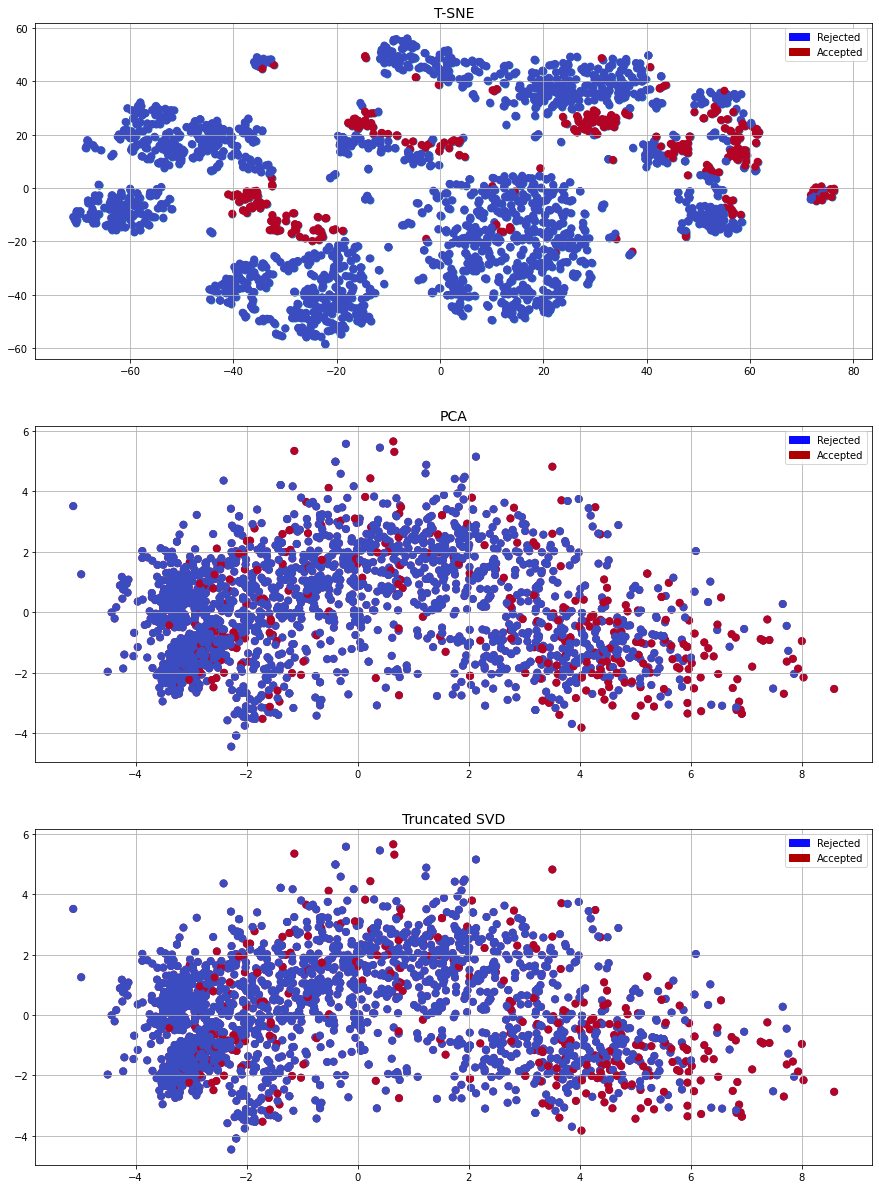

In [28]:
import matplotlib.patches as mpatches
fig, axs = plt.subplots(3,1, figsize=(15,21))
blue_patch = mpatches.Patch(color='#0A0AFF', label='Rejected')
red_patch = mpatches.Patch(color='#AF0000', label='Accepted')

#TSNE scatter plot
axs[0].scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], cmap='coolwarm', 
              label='Rejected', linewidths=2)
axs[0].scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1],c=(y==1), cmap='coolwarm', 
              label='Accepted', linewidths=2)
axs[0].set_title('T-SNE', size=14)
axs[0].grid(True)
axs[0].legend(handles=[blue_patch,red_patch])

#PCA scatter plot
axs[1].scatter(X_reduced_pca[:,0], X_reduced_pca[:,1],c=(y==0), cmap='coolwarm', 
              label='Rejected', linewidths=2)
axs[1].scatter(X_reduced_pca[:,0], X_reduced_pca[:,1],c=(y==1), cmap='coolwarm', 
              label='Accepted', linewidths=2)
axs[1].set_title('PCA', size=14)
axs[1].grid(True)
axs[1].legend(handles=[blue_patch,red_patch])

# Truncated SVD plot
axs[2].scatter(X_reduced_svd[:,0], X_reduced_svd[:,1],c=(y==0), cmap='coolwarm', 
              label='Rejected', linewidths=2)
axs[2].scatter(X_reduced_svd[:,0], X_reduced_svd[:,1],c=(y==1), cmap='coolwarm', 
              label='Accepted', linewidths=2)
axs[2].set_title('Truncated SVD', size=14)
axs[2].grid(True)
axs[2].legend(handles=[blue_patch,red_patch])

plt.show()

# Clustering

## K-Means

Silhouette score for k= 2


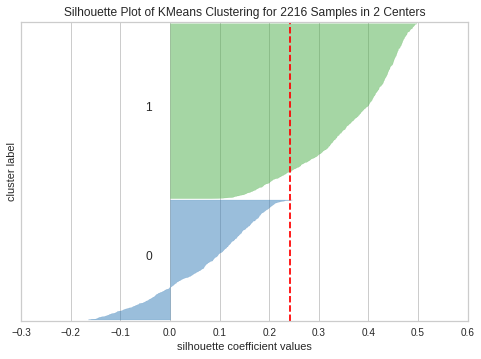

Silhouette score for k= 3


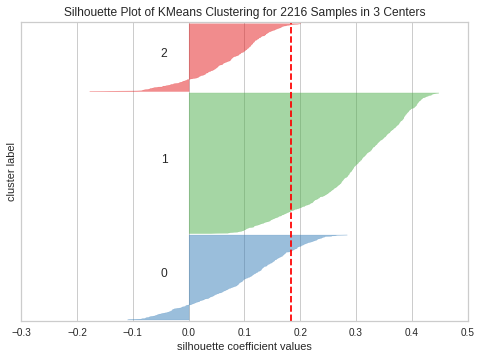

Silhouette score for k= 4


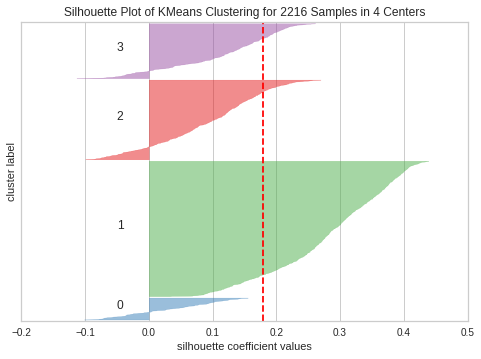

Silhouette score for k= 5


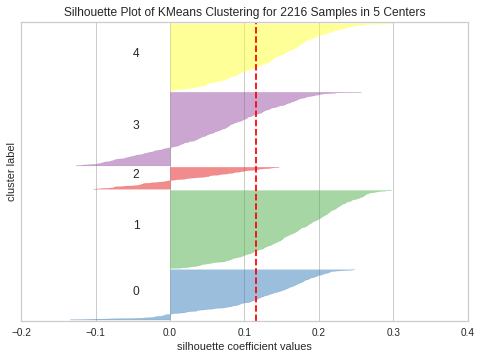

Silhouette score for k= 6


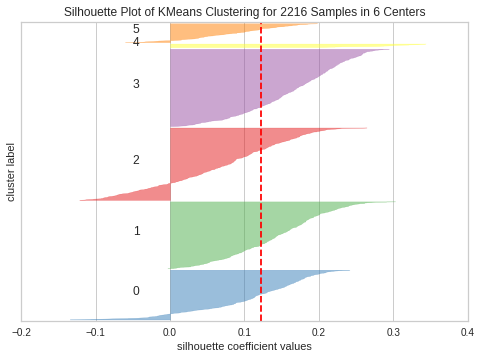

Silhouette score for k= 7


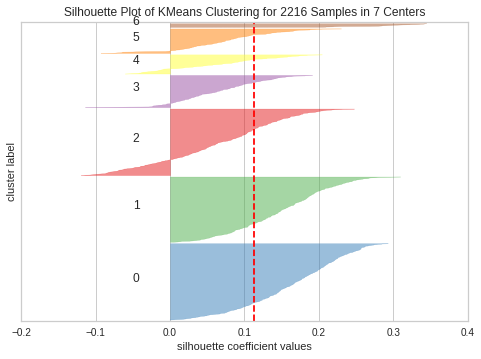

Silhouette score for k= 8


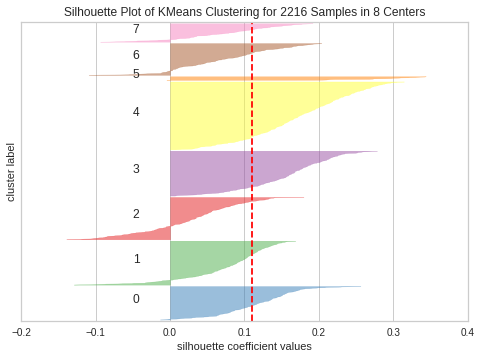

Silhouette score for k= 9


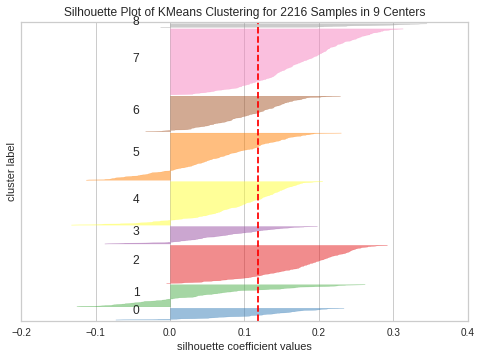

In [29]:
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.cluster import KMeans
for i in range(2,10):
    kmeans = KMeans(n_clusters=i, init ='k-means++', n_init=10, 
                    max_iter=100, random_state=42)
    visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
    print('Silhouette score for k= ' + str(i))
    visualizer.fit(scaled_data)
    visualizer.poof()

We will use 5 clusters, as it has clusters of relatively similar sizes. The possibly mislabeled clusters are small in size too

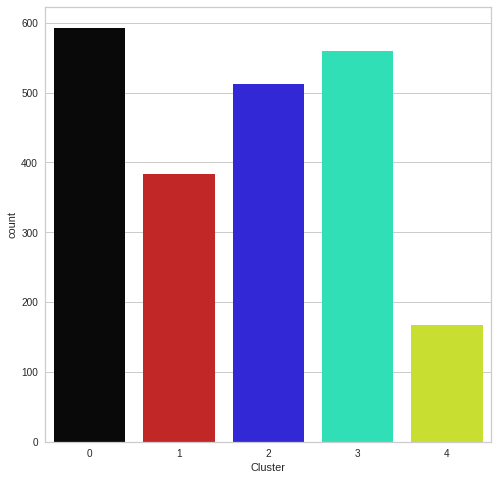

In [73]:
kmeans = KMeans(n_clusters=5)
cluster = kmeans.fit_predict(scaled_data)
df['Cluster'] = cluster
plt.figure(figsize=(8,8))
pal = ['#0A0909','#DC0D0D','#1A0BF3','#14FCC6','#DDFC14']#black, red,dark blue, light green, yellow
sns.countplot(df['Cluster'], palette = pal)
plt.show()

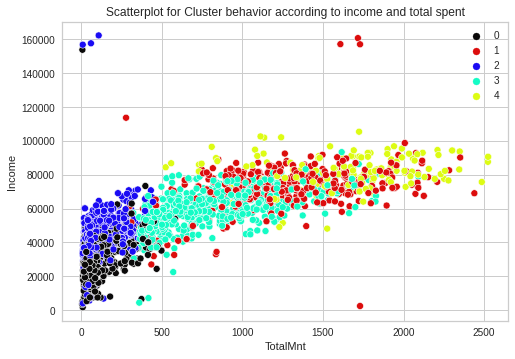

In [74]:
# There is an outlier in income column that we will remove
new_df = df[df['Income'] < 200000]
sns.scatterplot(x= 'TotalMnt', y='Income', hue = 'Cluster', data=new_df,
                palette = pal).set_title('Scatterplot for Cluster behavior according to income and total spent')
plt.legend()

In [75]:
print(df[['Income','TotalMnt','Age','Is_Parent']].describe())
df.groupby('Cluster').agg({'Income':'mean','TotalMnt':'mean','Age':'mean','Is_Parent':'mean'}).reset_index()

              Income     TotalMnt          Age    Is_Parent
count    2216.000000  2216.000000  2216.000000  2216.000000
mean    52247.251354   607.075361    45.179603     0.714350
std     25173.076661   602.900476    11.985554     0.451825
min      1730.000000     5.000000    18.000000     0.000000
25%     35303.000000    69.000000    37.000000     0.000000
50%     51381.500000   396.500000    44.000000     1.000000
75%     68522.000000  1048.000000    55.000000     1.000000
max    666666.000000  2525.000000   121.000000     1.000000


,Cluster,Income,TotalMnt,Age,Is_Parent
0,0,29920.112985,102.303541,36.490725,0.797639
1,1,74729.302083,1265.479167,45.945312,0.104167
2,2,43160.519531,128.023438,50.457031,0.984375
3,3,59984.610714,825.214286,49.230357,0.969643
4,4,81746.479042,1622.760479,44.508982,0.137725


There are 5 cluster patterns:<br>
* **Cluster 0**
> They have low incomes and low spending. This can explain why they do not spend much. The store should not target them in campaigns since they do not spend much.

* **Cluster 1**
>  They have high incomes and high spending. These are customers that spend a lot in stores and seem contented with the store services hence their spending.The cluster aso has a medium-aged people with very few people having children. The store should target them as well to maintain their spending levels.

* **Cluster 2** 
> They have average incomes and low spending. These are customers that spend lower than their limits. They have also the most children of all clusters. The cluster also has the people with the oldest customer population. These are either frugal customers or they are not content with the store's services hence choose not to spend. These are the customers that should be more targeted as they have the potential to spend even more.

* **Cluster 3**
> They have average incomes and average spending. These are customers that spend within their limit and are content with the store. They are also older than the average store customers. Most people in the cluster also have children which could explain the money management. They should not be the main target of promotions as the stores can maintain them as customers without much advertising.

* **Cluster 4**
> They have high incomes and extremely high spending. These are high income earners, with extravagant spending. They have also very few people having children and are of medium age. They should be the primary target of the store given their ability to spend.


**Which Clusters reponded well to the campaigns**

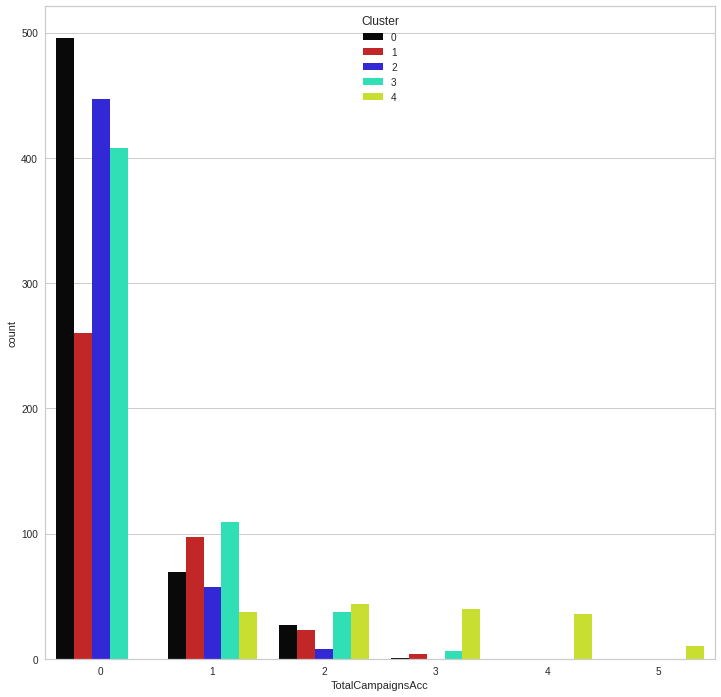

In [76]:
plt.figure(figsize=(12,12))
sns.countplot(df['TotalCampaignsAcc'], hue=df['Cluster'], palette = pal)
plt.show()

**Findings**<br>
1. Cluster 0 and cluster 2 did not respond well to the campaigns and most of the time said no. This can be explained by the fact that they have low incomes and low spending<br>
2. Cluster 4 were the most responsive of all clusters with some even accepting all the campaigns. This can be explained by their high incomes and exremely high spending levels

**Analysis of age and total purchases**

In [42]:
df.head()

,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Dependants,TotalMnt,TotalPurchases,TotalCampaignsAcc,Age,Is_Parent,Cluster
0,1957,1,1,58138.0,0,0,2012,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,1,0,1617,25,1,57,0,3
1,1954,1,1,46344.0,1,1,2014,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,0,2,27,6,0,60,1,0
2,1965,1,0,71613.0,0,0,2013,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,0,0,776,21,0,49,0,3
3,1984,1,0,26646.0,1,0,2014,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,0,1,53,8,0,30,1,0
4,1981,3,0,58293.0,1,0,2014,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,0,1,422,19,0,33,1,0


**Analysis of the efefct of being a parent**

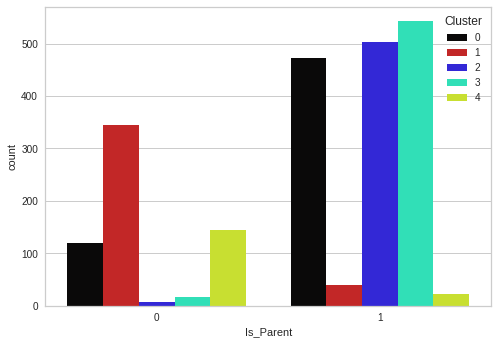

In [78]:
sns.countplot(x='Is_Parent', hue='Cluster', data=df, palette = pal)

**Findings**
* Majority of cluster 1 & 4 are not parents. Hence if you are targeting high spenders, who also repond well to the campaigns, people who have no chldren are a good place to start. and viceversa

**Analysis of the number of deals purchased**

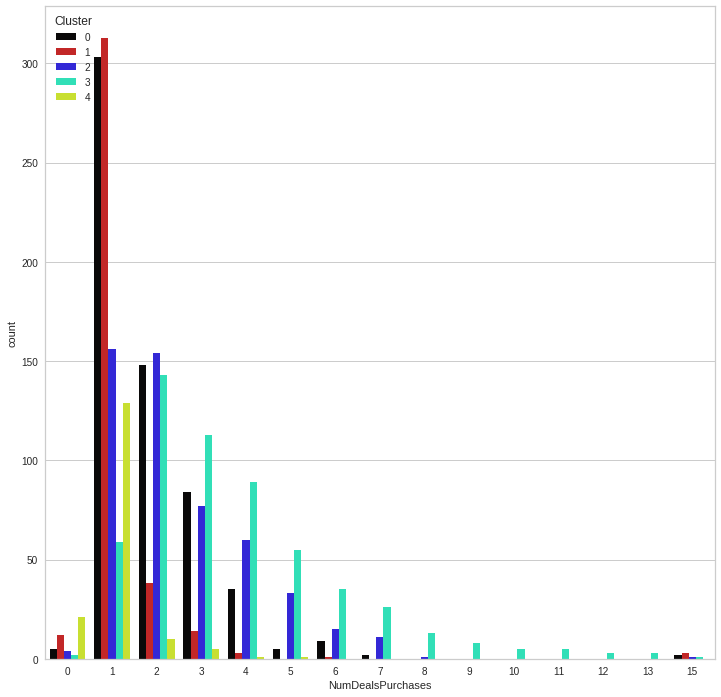

In [79]:
plt.figure(figsize=(12,12))
sns.countplot(x='NumDealsPurchases', hue='Cluster', data=df, palette = pal)

Cluster 3 were the most interested in purchasing the items that were ofefred on discount. Therefore, in future, if the store wanted to increase the sales of items on discount, it should focus on cluster 3

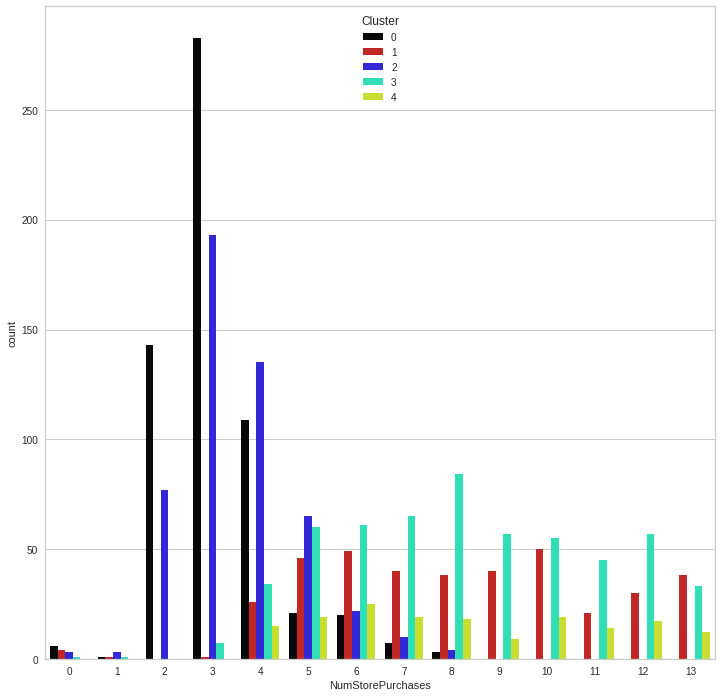

In [82]:
plt.figure(figsize=(12,12))
sns.countplot(x='NumStorePurchases', hue='Cluster', data=df, palette = pal)

Cluster 0 and 2, the ones with lower incomes tend to avoid store purchases. While cluster 1,3 & 4  preferred to do in store purchases.